In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sympy import * 
#from spring_damp import force_time, mass_damp_spring, ideal_actual, graphs
from spring_damp import mass_damp_spring, ideal_actual
import random
import yaml 
random.seed(63)

kk = mass_damp_spring(time = 2000, increment = 0.01, state = [0,0], force = sin, amplitude= 1,\
    omega = 0.1, no_mass = 5, range_mass= [10, 20], no_spring= 5, range_spring = [1,10], no_damp = 5, range_damp = [0.1, 1])
    

In [2]:
len(kk.mass) 

200001

In [3]:
ai = ideal_actual(time = 2000, increment = 0.01, state = [0,0], force = sin, amplitude= 1,\
    omega = 0.1, no_mass = 5, range_mass= [10, 20], no_spring= 5, range_spring = [1,10], no_damp = 5, range_damp = [0.1, 1], \
    delta_mass = 0, delta_spring = 0, delta_damp = 0) 

Text(0.5, 1.0, 'Force')

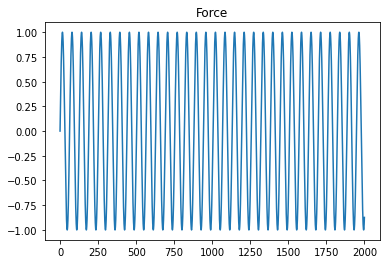

In [5]:
plt.plot(ai.time_array, ai.force_list)
plt.title("Force") 

Text(0.5, 1.0, 'mass')

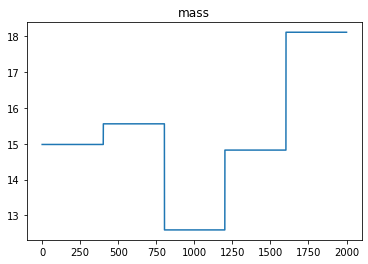

In [4]:
plt.plot(ai.time_array, ai.mass) 
plt.title("mass")

Text(0.5, 1.0, 'spring')

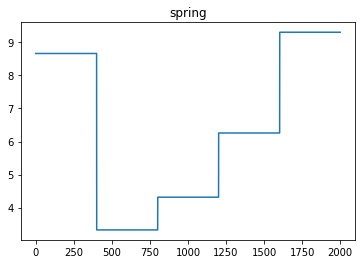

In [5]:
plt.plot(ai.time_array, ai.spring) 
plt.title("spring")  

Text(0.5, 1.0, 'Damp')

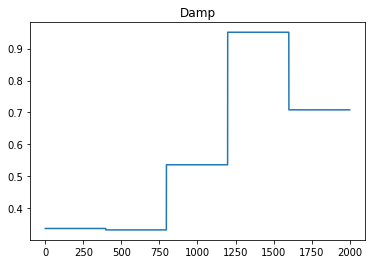

In [6]:
plt.plot(ai.time_array, ai.damp) 
plt.title("Damp")  

In [15]:
ideal_values = ai.ideal_values_list
ideal_acc = ai.ideal_acc 
from scipy.integrate import odeint 
def actual_diff(state, t):
    dx1dt = state[1] 
    T = int(t * ai.product)
    m = (ai.mass[T])
    f = ai.force_list[T] 
    b = ai.damp[T] * state[1] 
    k = ai.spring[T] * (state[0]**3)
    dx2dt = m * (f - b - k)
    dxdt = [dx1dt, dx2dt]
    return dxdt 

actual_values = odeint(actual_diff, ai.state, ai.time_array, mxstep=50000000) 

def error():
    z1 = list(actual_values[:,0]) #actual_disp
    z2 = list(ideal_values[:,0]) #ideal_disp
    error = []
    for i in range(len(ai.time_array)):
        e =  (-1)* (ai.spring[i]/ai.mass[i]) * ( z1[i] - z2[i])  
        error.append(e) 
    return error

E = error() 

Text(0.5, 1.0, 'Error')

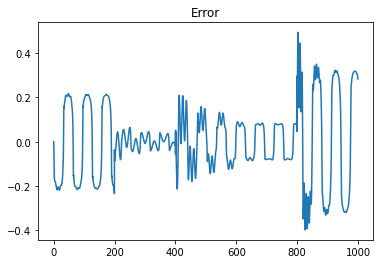

In [16]:
plt.plot(ai.time_array, E) 
plt.title("Error") 

In [17]:
#imp_colums = ["time_step", "force", "mass", "K", "B","actual_disp", "actual_vel", "G(x)"]

d = {
    "time" : ai.time_array,
    "force" : ai.force_list,
    "mass" : ai.mass,
    "K" : ai.spring,
    "B" : ai.damp,
    "actual_disp" : list(actual_values[:,0]),
    "actual_vel" : list(actual_values[:,1]),
    "G(x)" : E
    }
df = pd.DataFrame(d) 
df

,time,force,mass,K,B,actual_disp,actual_vel,G(x)
0,0.00,0.000000,14.451392,8.245848,0.289418,0.000000e+00,0.000000e+00,-0.000000e+00
1,0.01,0.001000,14.451392,8.245848,0.289418,7.629384e-16,1.642240e-09,6.715071e-12
2,0.02,0.002000,14.451392,8.245848,0.289418,7.126137e-07,1.415345e-04,-4.043920e-07
3,0.03,0.003000,14.451392,8.245848,0.289418,3.530230e-06,4.187750e-04,-2.004095e-06
4,0.04,0.004000,14.451392,8.245848,0.289418,9.771265e-06,8.262102e-04,-5.547459e-06
...,...,...,...,...,...,...,...,...
99996,999.96,-0.509811,10.870460,9.457679,0.616240,-3.810070e-01,2.036269e-02,2.834125e-01
99997,999.97,-0.508950,10.870460,9.457679,0.616240,-3.808031e-01,2.039580e-02,2.833087e-01
99998,999.98,-0.508089,10.870460,9.457679,0.616240,-3.805989e-01,2.042898e-02,2.832048e-01
99999,999.99,-0.507228,10.870460,9.457679,0.616240,-3.803944e-01,2.046221e-02,2.831006e-01


In [18]:
df.to_csv('Case_Study_K/K_case_study.csv', index=False)  

In [10]:
from sklearn.preprocessing import StandardScaler 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, RationalQuadratic, Exponentiation

ss = StandardScaler()

k = 9000//100 * (90) 
X_train = df.iloc[:k, :7]
y_train = df.iloc[:k, 7:]
X_test = df.iloc[k+1:, :7]
y_test = df.iloc[k+1:, 7:] 

x_tr = ss.fit_transform(X_train)
x_te = ss.fit_transform(X_test) 
y_tr = ss.fit_transform(y_train)
y_te = ss.fit_transform(y_test) 

rbf = ConstantKernel(1.0, (1e-1, 1e3) ) * RBF(10, (1e-7, 1e7))
white = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))
k = rbf + white

kernel = Exponentiation(RationalQuadratic(), exponent=3) 

rq =  ConstantKernel(1.0, (1e-1, 1e3) ) * RationalQuadratic(length_scale=1.0, alpha=2)

gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.1) 

gpr.fit(x_tr, y_tr)

GaussianProcessRegressor(alpha=0.1,
                         kernel=RationalQuadratic(alpha=1, length_scale=1) ** 3)

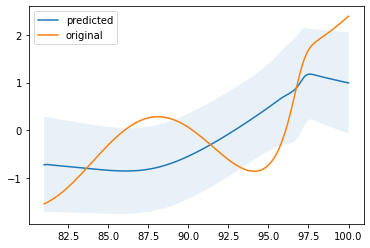

In [11]:
params = gpr.kernel_.get_params() 
mu_s, cov_s = gpr.predict(x_te, return_cov=True) 
mu_s = mu_s.ravel()

std = 1.96 * np.sqrt(np.diag(cov_s))
plt.plot(X_test['time'], mu_s)
plt.plot(X_test['time'], y_te)
plt.fill_between(X_test['time'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"]) 

In [12]:
import pickle
filename = 'GPR_preprocessing_output.sav'
pickle.dump(gpr, open(filename, 'wb'))

In [14]:
mass_dict, spring_dict, damp_dict = {}, {}, {}

for i in ai.mass:
    if i not in mass_dict:
        mass_dict[i] = 1
    mass_dict[i] += 1

for i in ai.spring:
    if i not in spring_dict:
        spring_dict[i] = 1
    spring_dict[i] += 1

for i in ai.damp:
    if i not in damp_dict:
        damp_dict[i] = 1
    damp_dict[i] += 1

In [16]:
mass_dict, spring_dict, damp_dict

({17.631615170020055: 2026,
  11.583641259595993: 1957,
  12.260900580981653: 2060,
  19.359173705208082: 1948,
  18.358350813154544: 2015},
 {5.69462341896126: 2042,
  7.57024447285004: 1986,
  6.77054060534559: 2018,
  6.967600975227811: 1984,
  2.640376601113613: 1976},
 {0.38403520064371444: 1955,
  0.1401250966550017: 2063,
  0.9326910794550998: 2008,
  0.8148013864211452: 2070,
  0.580526523947736: 1910})

# CASE_STUDY_1

In [27]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sympy import * 
#from spring_damp import force_time, mass_damp_spring, ideal_actual, graphs
from spring_damp import mass_damp_spring, ideal_actual
import random
random.seed(63) 

ai = ideal_actual(time = 100, increment = 0.01, state = [0,0], force = sin, amplitude= 1,\
    omega = 0.1, no_mass = 5, range_mass= [10, 20], no_spring= 5, range_spring = [1,10], no_damp = 5, range_damp = [0.1, 1], \
    delta_mass = 0, delta_spring = 0, delta_damp = 0) 

In [28]:
mass = ai.mass
damp = ai.damp 
spring = []
for i in range(len(mass)):
    if i >= 5000:
        spring.append(2.640376601113613)
    elif i < 5000:
        spring.append(5.69462341896126) 


In [29]:
len(spring), len(mass)

(10001, 10001)

Text(0.5, 1.0, 'mass')

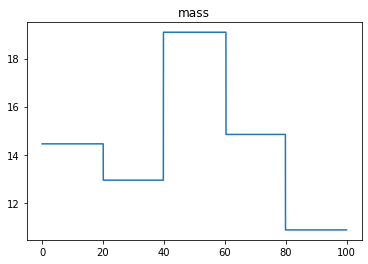

In [30]:
plt.plot(ai.time_array, mass) 
plt.title("mass")

Text(0.5, 1.0, 'spring')

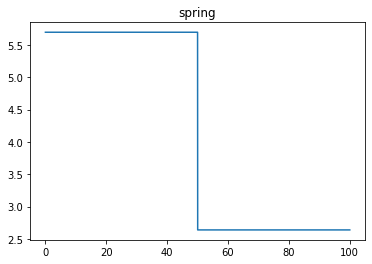

In [31]:
plt.plot(ai.time_array, spring) 
plt.title("spring")  

Text(0.5, 1.0, 'Damp')

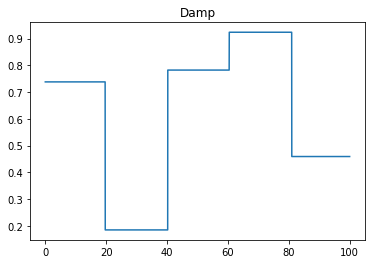

In [32]:
plt.plot(ai.time_array, damp) 
plt.title("Damp")  

In [33]:
from scipy.integrate import odeint 

def idead_diff(state, t):
    dx1dt = state[1]
    T = int(t*ai.product)
    dx2dt = (1/mass[T])*(ai.force_list[T] - 
                    (damp[T]*state[1]) - 
                    (spring[T] * state[0]) )
    dxdt = [dx1dt, dx2dt]
    return dxdt

ideal_values = odeint(idead_diff, ai.state, ai.time_array, mxstep=50000000)  

def actual_diff(state, t):
    dx1dt = state[1]
    T = int(t * ai.product)
    m = (mass[T])
    f = ai.force_list[T] 
    b = damp[T] * state[1] 
    k = spring[T] * (state[0]**3)
    dx2dt = m * (f - b - k)
    dxdt = [dx1dt, dx2dt]
    return dxdt 

actual_values = odeint(actual_diff, ai.state, ai.time_array, mxstep=50000000) 

def error():
    z1 = list(actual_values[:,0]) #actual_disp
    z2 = list(ideal_values[:,0]) #ideal_disp
    error = []
    for i in range(len(ai.time_array)):
        e =  (-1)* (spring[i]/mass[i]) * ( z1[i] - z2[i])  
        error.append(e) 
    return error

E = error() 

Text(0.5, 1.0, 'Error')

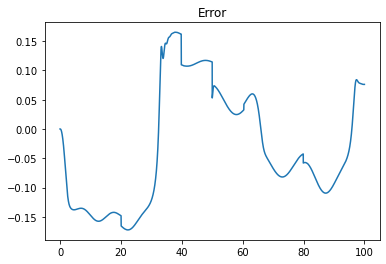

In [34]:
plt.plot(ai.time_array, E) 
plt.title("Error") 

In [35]:
d = {
    "time" : ai.time_array,
    "force" : ai.force_list,
    "mass" : mass,
    "K" : spring,
    "B" : damp,
    "actual_disp" : list(actual_values[:,0]),
    "actual_vel" : list(actual_values[:,1]),
    "G(x)" : E
    }

df_case_1 = pd.DataFrame(d) 
df_case_1

,time,force,mass,K,B,actual_disp,actual_vel,G(x)
0,0.00,0.000000,14.451392,5.694623,0.738188,0.000000e+00,0.000000e+00,-0.000000e+00
1,0.01,0.001000,14.451392,5.694623,0.738188,1.023082e-15,2.643933e-09,4.617818e-12
2,0.02,0.002000,14.451392,5.694623,0.738188,6.996418e-07,1.370629e-04,-2.741641e-07
3,0.03,0.003000,14.451392,5.694623,0.738188,3.395523e-06,3.973178e-04,-1.330960e-06
4,0.04,0.004000,14.451392,5.694623,0.738188,9.256405e-06,7.683397e-04,-3.628233e-06
...,...,...,...,...,...,...,...,...
9996,99.96,-0.540660,10.870460,2.640377,0.459275,-5.840365e-01,-3.217264e-02,7.613070e-02
9997,99.97,-0.541501,10.870460,2.640377,0.459275,-5.843580e-01,-3.211390e-02,7.613519e-02
9998,99.98,-0.542342,10.870460,2.640377,0.459275,-5.846789e-01,-3.205500e-02,7.613996e-02
9999,99.99,-0.543182,10.870460,2.640377,0.459275,-5.849993e-01,-3.199611e-02,7.614501e-02


In [36]:
df_case_1.to_csv('K_case_study_1.csv', index=False)  

In [37]:
from sklearn.preprocessing import StandardScaler 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, RationalQuadratic, Exponentiation

ss = StandardScaler()
x_1 = df_case_1.iloc[:,:7]
y_1 = df_case_1.iloc[:,7:] 
X = ss.fit_transform(x_1) 
y = ss.fit_transform(y_1) 

In [38]:
import pickle
filename = 'GPR_preprocessing_output.sav'
gpr = pickle.load(open(filename, 'rb'))

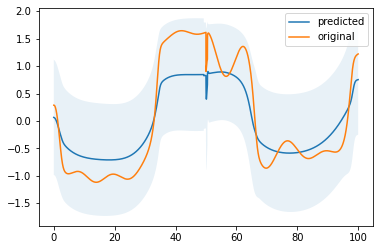

In [15]:
mu_s, cov_s = gpr.predict(X, return_cov=True) 
mu_s = mu_s.ravel()

std = 1.96 * np.sqrt(np.diag(cov_s))
plt.plot(x_1['time'], mu_s) 
plt.plot(x_1['time'], y)
plt.fill_between(x_1['time'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"]) 

# CASE_STUDY_2 (k = 5.69462341896126)

In [16]:
k_2 = []
for i in range(len(ai.mass)):
    k_2.append(5.69462341896126)

d = {
    "time" : ai.time_array,
    "force" : ai.force_list,
    "mass" : mass,
    "K" : k_2,
    "B" : damp,
    "actual_disp" : list(actual_values[:,0]),
    "actual_vel" : list(actual_values[:,1]),
    "G(x)" : E
    }

df_case_2 = pd.DataFrame(d) 
df_case_2

,time,force,mass,K,B,actual_disp,actual_vel,G(x)
0,0.00,0.000000,17.631615,5.694623,0.887456,0.000000e+00,0.000000e+00,-0.000000e+00
1,0.01,0.001000,17.631615,5.694623,0.887456,6.790693e-15,2.660347e-09,1.260518e-12
2,0.02,0.002000,17.631615,5.694623,0.887456,8.381994e-07,1.631817e-04,-2.696978e-07
3,0.03,0.003000,17.631615,5.694623,0.887456,4.023373e-06,4.659606e-04,-1.294550e-06
4,0.04,0.004000,17.631615,5.694623,0.887456,1.084921e-05,8.881059e-04,-3.490776e-06
...,...,...,...,...,...,...,...,...
9996,99.96,-0.540660,11.583641,5.694623,0.962522,-5.769714e-01,-3.537042e-02,8.593801e-02
9997,99.97,-0.541501,11.583641,5.694623,0.962522,-5.773246e-01,-3.526077e-02,8.596928e-02
9998,99.98,-0.542342,11.583641,5.694623,0.962522,-5.776768e-01,-3.515278e-02,8.600032e-02
9999,99.99,-0.543182,11.583641,5.694623,0.962522,-5.780279e-01,-3.504644e-02,8.603114e-02


In [21]:
x_2 = df_case_2.iloc[:,:7]
y_2 = df_case_2.iloc[:,7:] 
X = ss.fit_transform(x_2) 
y = ss.fit_transform(y_2) 

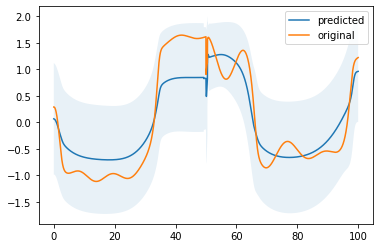

In [22]:
mu_s, cov_s = gpr.predict(X, return_cov=True) 
mu_s = mu_s.ravel()

std = 1.96 * np.sqrt(np.diag(cov_s))
plt.plot(x_2['time'], mu_s) 
plt.plot(x_2['time'], y)
plt.fill_between(x_2['time'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"]) 

# CASE_STUDY_3 (k = 2.640376601113613)

In [23]:
k_3 = []
for i in range(len(ai.mass)):
    k_3.append(2.64037660)

d = {
    "time" : ai.time_array,
    "force" : ai.force_list,
    "mass" : mass,
    "K" : k_3,
    "B" : damp,
    "actual_disp" : list(actual_values[:,0]),
    "actual_vel" : list(actual_values[:,1]),
    "G(x)" : E
    }

df_case_3 = pd.DataFrame(d) 
df_case_3

,time,force,mass,K,B,actual_disp,actual_vel,G(x)
0,0.00,0.000000,17.631615,2.640377,0.887456,0.000000e+00,0.000000e+00,-0.000000e+00
1,0.01,0.001000,17.631615,2.640377,0.887456,6.790693e-15,2.660347e-09,1.260518e-12
2,0.02,0.002000,17.631615,2.640377,0.887456,8.381994e-07,1.631817e-04,-2.696978e-07
3,0.03,0.003000,17.631615,2.640377,0.887456,4.023373e-06,4.659606e-04,-1.294550e-06
4,0.04,0.004000,17.631615,2.640377,0.887456,1.084921e-05,8.881059e-04,-3.490776e-06
...,...,...,...,...,...,...,...,...
9996,99.96,-0.540660,11.583641,2.640377,0.962522,-5.769714e-01,-3.537042e-02,8.593801e-02
9997,99.97,-0.541501,11.583641,2.640377,0.962522,-5.773246e-01,-3.526077e-02,8.596928e-02
9998,99.98,-0.542342,11.583641,2.640377,0.962522,-5.776768e-01,-3.515278e-02,8.600032e-02
9999,99.99,-0.543182,11.583641,2.640377,0.962522,-5.780279e-01,-3.504644e-02,8.603114e-02


In [25]:
x_3 = df_case_3.iloc[:,:7]
y_3 = df_case_3.iloc[:,7:] 
X = ss.fit_transform(x_3) 
y = ss.fit_transform(y_3) 

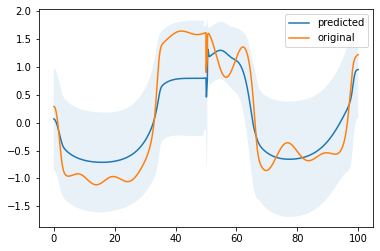

In [26]:
mu_s, cov_s = gpr.predict(X, return_cov=True) 
mu_s = mu_s.ravel()

std = 1.96 * np.sqrt(np.diag(cov_s))
plt.plot(x_2['time'], mu_s) 
plt.plot(x_2['time'], y)
plt.fill_between(x_2['time'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"])  